# Weak lensing – Notebook 11th April 2024

Notebook tested with commit nb `a8a25e441996bbda61298608c46db620666f26f9`.

Check requirements in `env.yml` (conda virtual environment).

The `pycs` package from the `cosmostat` repository (https://github.com/CosmoStat/cosmostat) could not be installed with `pip install .`. Therefore, the path to the git repository must be added to `PYTHONPATH` (see below). Tested with commit nb `2474c0332f926cc90c7b4c15bb19ee4b459ba3fc`.

The `pysparse` package from the `Sparse2D` repository  (https://github.com/CosmoStat/Sparse2D) needs to be manually installed. Tested with commit nb `3f9d54863765980299cfe92e0624ba93ed7ff02b`.

Very dirty workaround to avoid `ImportError: libpython3.11.so.1.0: cannot open shared object file: No such file or directory`: create a symbolic link from the `libpython3.11.so.1.0` file, which is typically stored in the `~/miniconda3/envs/wl-pycs/lib` (i.e., the directory for shared libraries within the virtual environment), to a standard root location such as `/lib/x86_64-linux-gnu`.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import pickle

import numpy as np
from scipy import stats, optimize
import matplotlib.pyplot as plt

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import weaklensing as wl
import weaklensing.utils as wlutils
import weaklensing.kappatng as wlktng
import weaklensing.cosmos as wlcosmos

pycs_dir = os.path.expanduser(wl.CONFIG_DATA['pycs_dir'])
sys.path.append(pycs_dir) # tested with commit nb 2474c0332f926cc90c7b4c15bb19ee4b459ba3fc)
print(f"The `pycs` package is located in {pycs_dir}")

import pycs.astro.wl.mass_mapping as csmm

Configuration file found in /home/leterme231/OneDrive/Documents/Code/weaklensing
The `pycs` package is located in /home/leterme231/OneDrive/Documents/Code/cosmostat


In [3]:
path_to_paper = os.path.expanduser("~/Dropbox/postdoc-hubert/papers/2024-04_AA/img")

## Conformal quantile regression: test calibration functions

### Examples of calibration functions

In [4]:
r = np.linspace(0, 0.08, 101)

#### Additive calibration functions (original paper)

$$g_\lambda(r) := \max(0,\, r + \lambda)$$

In [5]:
def g(lamb, r):
    return np.maximum(0, r + lamb)

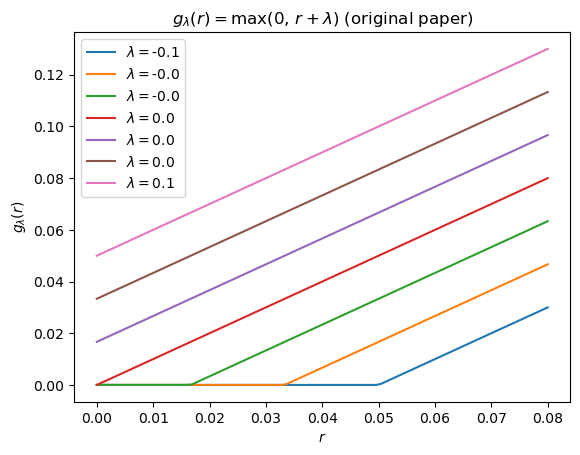

In [6]:
for lamb in np.linspace(-.05, .05, 7):
    plt.plot(r, g(lamb, r),  label=r"$\lambda =$" + f"{lamb:.1f}")
lamb = 4.
plt.xlabel(r"$r$")
plt.ylabel(r"$g_\lambda(r)$")
plt.legend()
plt.title(r"$g_\lambda(r) = \max(0,\, r + \lambda)$ (original paper)")
plt.show()

#### Multiplicative calibration functions

$$g_\lambda(r) := \lambda r$$

In [7]:
def g(lamb, r):
    return lamb * r

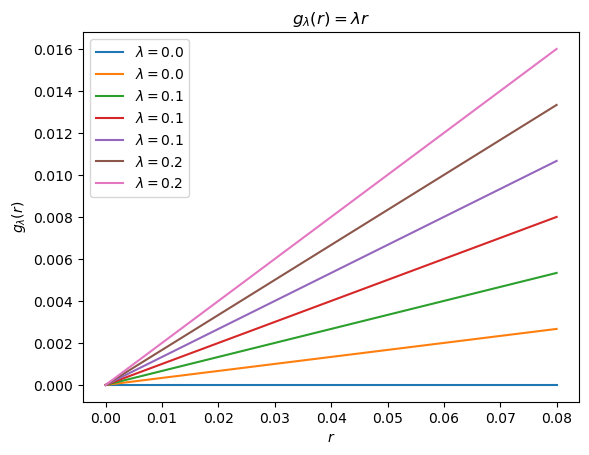

In [8]:
for lamb in np.linspace(0., .2, 7):
    plt.plot(r, g(lamb, r),  label=r"$\lambda =$" + f"{lamb:.1f}")
lamb = 4.
plt.xlabel(r"$r$")
plt.ylabel(r"$g_\lambda(r)$")
plt.legend()
plt.title(r"$g_\lambda(r) = \lambda r$")
plt.show()

#### Exponential calibration functions

$$g_{\lambda,\ s}(r) := s \rho(r/s) (\mathrm e^\lambda - 1) + r$$

In [9]:
def g(lamb, rho, r, scalefact=1.):
    weights = scalefact * rho(r / scalefact)
    return weights * (np.exp(lamb) - 1) + r

In [10]:
def plot_func_family(rho, r, scalefact, lambs, bottom, top, title, xticks=None, xticklabels=None):
    plt.plot(r, g(-np.inf, rho, r, scalefact=scalefact),  label=r"$\lambda = -\infty$")
    for lamb in lambs:
        plt.plot(r, g(lamb, rho, r, scalefact=scalefact),  label=r"$\lambda =$" + f"{lamb:.1f}")
    plt.ylim(bottom=bottom,top=top)
    plt.xlabel(r"$r$")
    plt.xticks(xticks, labels=xticklabels)
    plt.title(
        title + r", $s = $" + f"{scalefact:.1e}"
    )
    plt.legend()
    plt.show()

$$\rho(r) := r + \mathrm e^{-r} - 1$$

In [11]:
def rho1(r):
    return r + np.exp(-r) - 1

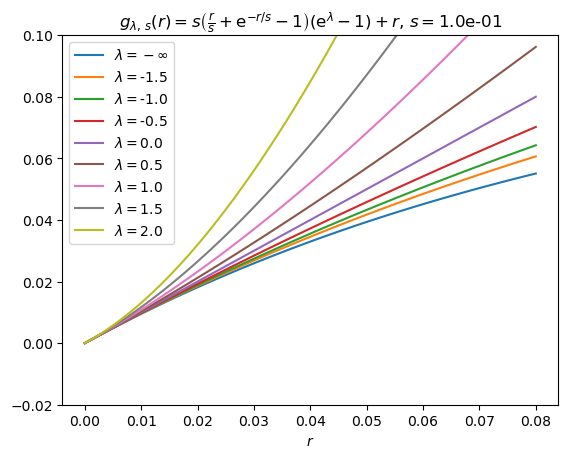

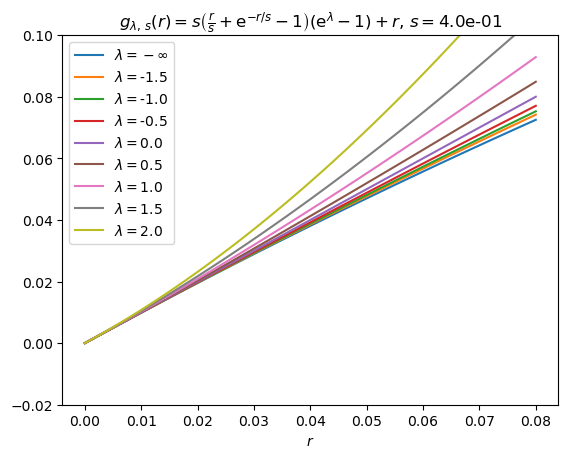

In [12]:
lambs = np.linspace(-1.5, 2., 8)
bottom = -.02
top = .1
title = (
    r"$g_{\lambda,\, s}(r) = s \left(\frac{r}{s} + "
    r"\mathrm{e}^{-r/s} - 1\right)(\mathrm{e}^\lambda - 1) + r$"
)

scalefacts1 = np.linspace(.1, .5, 5)
for scalefact in scalefacts1:
    plot_func_family(rho1, r, scalefact, lambs, bottom, top, title)

$$\rho(r) := \beta F_{\chi^2}(r),$$
where $F_{\chi^2}$ denotes the cumulative distribution function of a chi-squared distribution.

In [13]:
df = 3.
pdf = stats.chi2.pdf(r, df)

In [14]:
# Get the maximal value for parameter `beta` (in order `g` to remain non-descending):
def neg_chi2_pdf(*args, **kwargs):
    return -stats.chi2.pdf(*args, **kwargs)

opt = optimize.minimize_scalar(neg_chi2_pdf, args=(df,))
argmax_beta = opt.x
max_beta = -1 / opt.fun
print(f"Maximal value for beta = {max_beta:.2f}")

Maximal value for beta = 4.13


In [15]:
beta = max_beta
rho2 = lambda r: beta * stats.chi2.cdf(r, df)

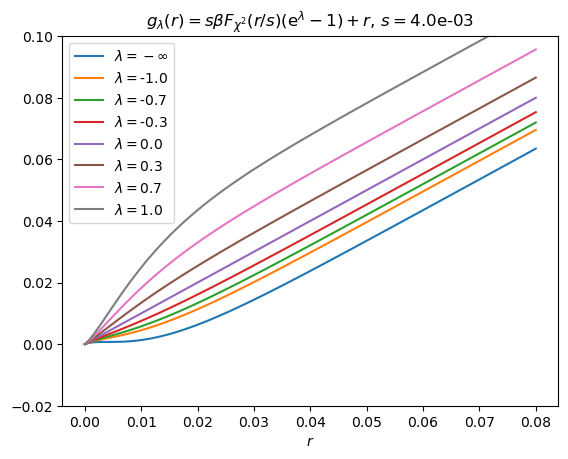

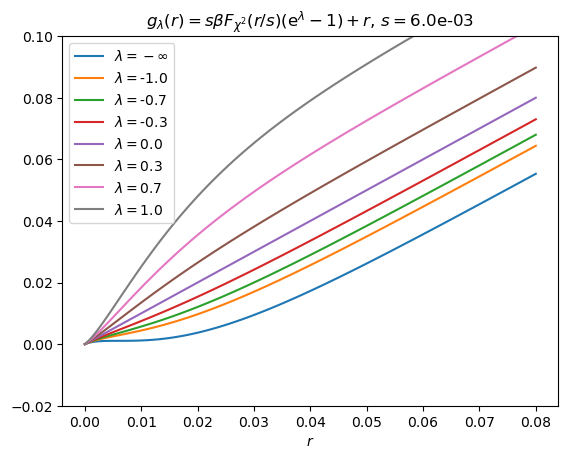

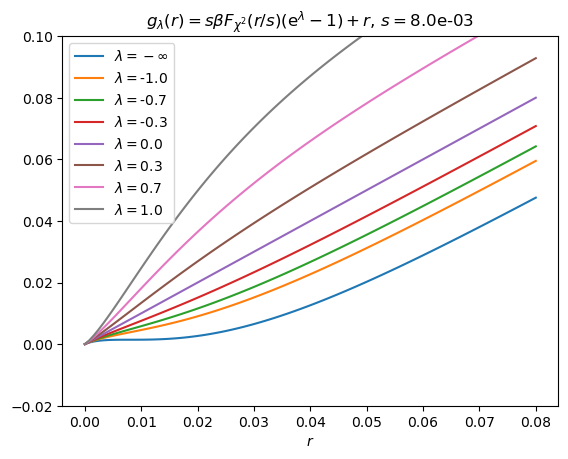

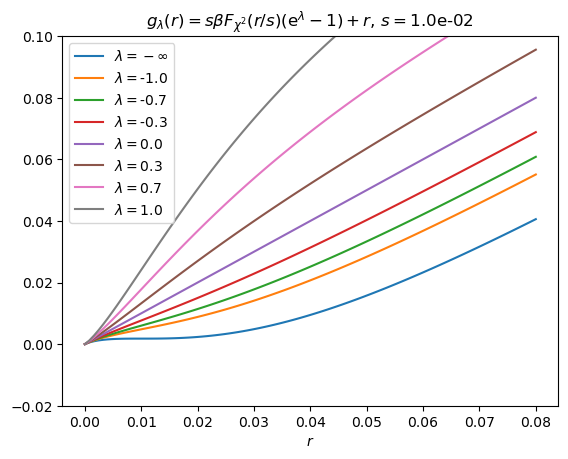

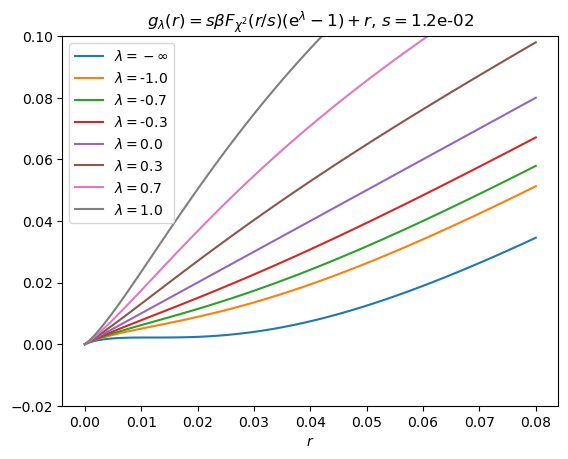

In [16]:
lambs = np.linspace(-1., 1., 7)
bottom = -.02
top = 0.1
title = (
    r"$g_\lambda(r) = s \beta F_{\chi^2}(r/s) (\mathrm{e}^\lambda - 1) + r$"
)

scalefacts2 = np.linspace(.004, .012, 5)
for scalefact in scalefacts2:
    plot_func_family(rho2, r, scalefact, lambs, bottom, top, title)

### Compute Kaiser-Squires, Wiener and MCALens

In [17]:
size = 1.5
width, size = wlktng.get_npixels(size)
Nsigma = 4
Nrea = 25 # Number of noise realizations for UQ
print(f"Nb of pixels per side = {width}")
print(f"Opening angle = {size:.2f} deg")

Nb of pixels per side = 306
Opening angle = 1.49 deg


Load kappaTNG dataset

In [18]:
index_redshift = 2
ninpimgs = 25
kappa = wlktng.kappa_tng(index_redshift, ninpimgs, width=width)
%store kappa

Stored 'kappa' (ndarray)


Load data from the COSMOS catalog

In [19]:
cat_cosmos = wlcosmos.cosmos_catalog(
    include_faint=False
)
data_cosmos = wlcosmos.get_data_from_cosmos(cat_cosmos, size)
extent = data_cosmos["extent"]
cosmos_mask, ra, dec = wlcosmos.cosmos_boundaries(extent, width)

In [20]:
shapedisp1, shapedisp2 = data_cosmos["shapedisp"]
shapedisp = (shapedisp1 + shapedisp2) / 2

print(f"Shape dispersion 1 = {shapedisp1:.3f}")
print(f"Shape dispersion 2 = {shapedisp2:.3f}")

Shape dispersion 1 = 0.278
Shape dispersion 2 = 0.279


In [21]:
print(f"Resolution = {wlktng.RESOLUTION:.2f} arcmin/pixel")

Resolution = 0.29 arcmin/pixel


Map of number of galaxies per pixel

In [22]:
ngal = wlutils.ngal_per_pixel(cat_cosmos["Ra"], cat_cosmos["Dec"], width, extent)
%store ngal

Stored 'ngal' (ndarray)


In [23]:
plt.figure(figsize=(5, 3))
wlutils.skyshow(
    ngal, extent=extent, boundaries=(ra, dec),
    #title="Number of galaxies per pixel"
)
plt.gcf().set_facecolor('none')
plt.show()

Create noisy shear maps

In [24]:
gamma1, gamma2 = wlutils.get_shear_from_convergence(kappa)
gamma1_noisy, gamma2_noisy, std_noise = wlutils.get_masked_and_noisy_shear(
    gamma1, gamma2, ngal, shapedisp, stdnoise_mask=0
)
%store gamma1 gamma2 gamma1_noisy gamma2_noisy

/home/leterme231/OneDrive/Documents/Code/weaklensing/weaklensing/utils.py:141: RuntimeWarning: divide by zero encountered in divide
  shapedisp / np.sqrt(ngal), posinf=stdnoise_mask


Stored 'gamma1' (ndarray)
Stored 'gamma2' (ndarray)
Stored 'gamma1_noisy' (ndarray)
Stored 'gamma2_noisy' (ndarray)


In [25]:
idx = 0
vmin = np.min(kappa)
vmax = np.max(kappa)
vmin_gamma = min(np.min(gamma1), np.min(gamma2))
vmax_gamma = max(np.max(gamma1), np.max(gamma2))
saturation = 0.4
saturation_gamma = 0.4

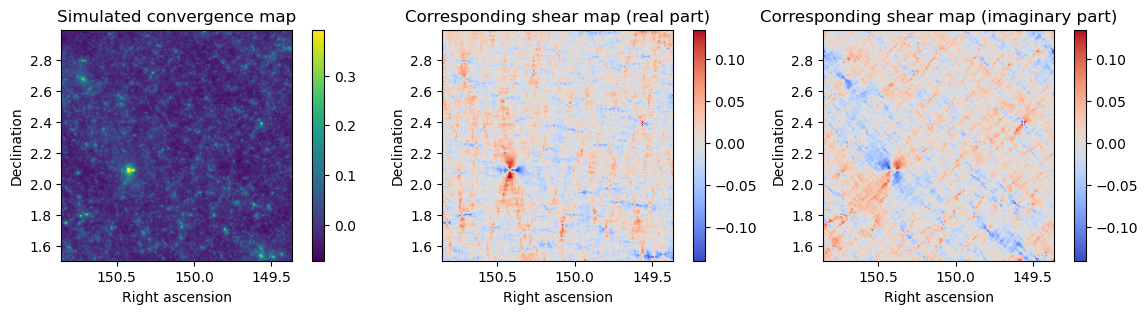

In [26]:
plt.figure(figsize=(15, 3))
plt.subplot(131)
wlutils.skyshow(
    kappa[idx], vmin=vmin, vmax=saturation*vmax, extent=extent,
    title="Simulated convergence map"
)
plt.subplot(132)
wlutils.skyshow(
    gamma1[idx], cmap='coolwarm', vmin=saturation_gamma*vmin_gamma, vmax=saturation_gamma*vmax_gamma,
    extent=extent, c='k', title="Corresponding shear map (real part)"
)
plt.subplot(133)
wlutils.skyshow(
    gamma2[idx], cmap='coolwarm', vmin=saturation_gamma*vmin_gamma, vmax=saturation_gamma*vmax_gamma,
    extent=extent, c='k', title="Corresponding shear map (imaginary part)"
)
plt.subplots_adjust(wspace=-0.05)
plt.show()

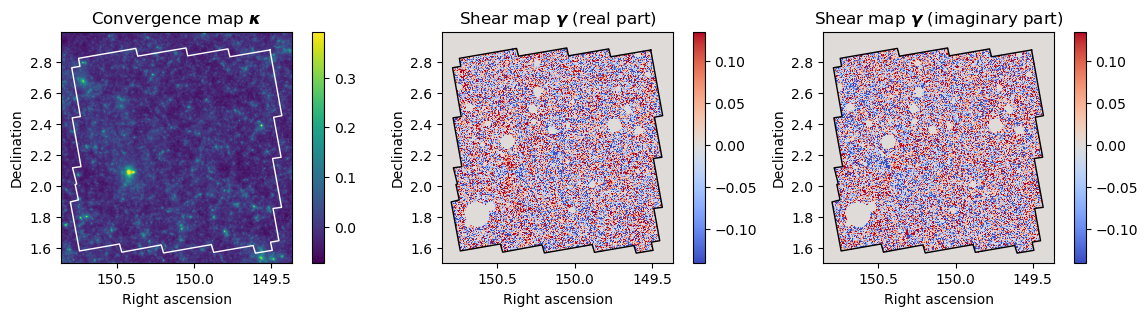

In [27]:
plt.figure(figsize=(15, 3))
plt.subplot(131)
wlutils.skyshow(
    kappa[idx], vmin=vmin, vmax=saturation*vmax, extent=extent,
    boundaries=(ra, dec), title=r"Convergence map $\boldsymbol{\kappa}$"
)
plt.subplot(132)
wlutils.skyshow(
    gamma1_noisy[idx], cmap='coolwarm', vmin=saturation_gamma*vmin_gamma, vmax=saturation_gamma*vmax_gamma,
    extent=extent, boundaries=(ra, dec), c='k', title=r"Shear map $\boldsymbol{\gamma}$ (real part)"
)
plt.subplot(133)
wlutils.skyshow(
    gamma2_noisy[idx], cmap='coolwarm', vmin=saturation_gamma*vmin_gamma, vmax=saturation_gamma*vmax_gamma,
    extent=extent, boundaries=(ra, dec), c='k', title=r"Shear map $\boldsymbol{\gamma}$ (imaginary part)"
)
plt.subplots_adjust(wspace=-0.05)
plt.show()

In [28]:
plt.figure(figsize=(5, 3))
wlutils.skyshow(
    kappa[idx], vmin=vmin, vmax=saturation*vmax, extent=extent,
    boundaries=(ra, dec), printxylabels=False
)
plt.savefig(os.path.join(path_to_paper, "convmap.pdf"), bbox_inches='tight')
plt.close()

plt.figure(figsize=(5, 3))
wlutils.skyshow(
    gamma1_noisy[idx], cmap='coolwarm', vmin=saturation_gamma*vmin_gamma, vmax=saturation_gamma*vmax_gamma,
    extent=extent, boundaries=(ra, dec), c='k', printxylabels=False
)
plt.savefig(os.path.join(path_to_paper, "shearmap_re.pdf"), bbox_inches='tight')
plt.close()

plt.figure(figsize=(5, 3))
wlutils.skyshow(
    gamma2_noisy[idx], cmap='coolwarm', vmin=saturation_gamma*vmin_gamma, vmax=saturation_gamma*vmax_gamma,
    extent=extent, boundaries=(ra, dec), c='k', printxylabels=False
)
plt.savefig(os.path.join(path_to_paper, "shearmap_im.pdf"), bbox_inches='tight')
plt.close()

In [29]:
confidence = 2. # Level of confidence (n-sigma)
alpha = wlutils.get_alpha_from_confidence(confidence)

min_nimgs_calib = wlutils.get_min_nimgs_calib(alpha)
print(f"Confidence level of {confidence}-sigma --> alpha = {alpha:.1%}")
print(f"Smallest possible size for the calibration set = {min_nimgs_calib}")

Confidence level of 2.0-sigma --> alpha = 4.6%
Smallest possible size for the calibration set = 21


In [30]:
nimgs_calib = 100
nimgs = kappa.shape[0]
nimgs_test = nimgs - nimgs_calib
print(f"Size of the calibration set = {nimgs_calib}")
print(f"Size of the test set = {nimgs_test}")

Size of the calibration set = 100
Size of the test set = 125


Register data into a `csmm.shear_data` object

In [31]:
sheardata = csmm.shear_data()
sheardata.g1 = gamma1_noisy
sheardata.g2 = gamma2_noisy
sheardata.mask = (ngal > 0).astype(int)
sheardata.Ncov = 2 * std_noise**2 # factor 2 required

Create a mass mapping structure and initialize it

In [32]:
massmap = csmm.massmap2d(name='mass')
massmap.init_massmap(width, width)
massmap.DEF_Nsigma = Nsigma

print(f"Number of iterations (iterative methods): {massmap.DEF_niter}")
print(f"Detection level in wavelet space: {massmap.DEF_Nsigma}")

Number of iterations (iterative methods): 12
Detection level in wavelet space: 4


#### Kaiser-Squires estimator

In [33]:
_, kappa_ks_lo, kappa_ks_hi, _ = wlutils.ksfilter(
    gamma1_noisy, gamma2_noisy,
    std_noise=std_noise, confidence=confidence
)
kappa_ks = (kappa_ks_lo + kappa_ks_hi) / 2
res_ks = (kappa_ks_hi - kappa_ks_lo) / 2

%store kappa_ks res_ks

Stored 'kappa_ks' (ndarray)
Stored 'res_ks' (ndarray)


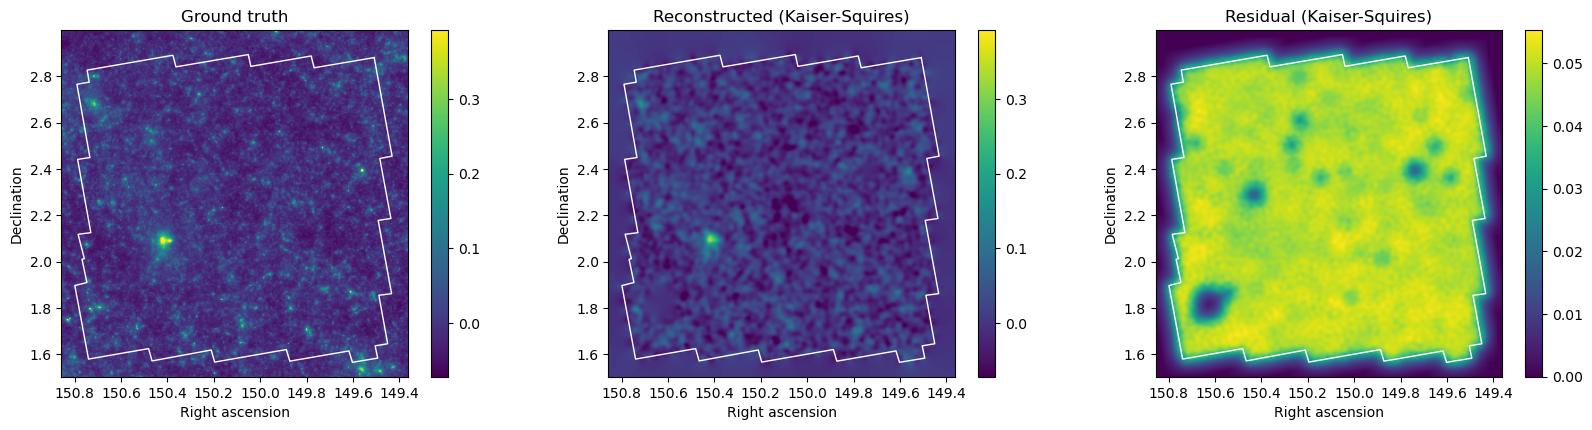

In [34]:
plt.figure(figsize=(20, 4.5))
plt.subplot(131)
wlutils.skyshow(
    kappa[idx], vmin=vmin, vmax=saturation*vmax, extent=extent,
    boundaries=(ra, dec), title="Ground truth"
)
plt.subplot(132)
wlutils.skyshow(
    kappa_ks[idx], vmin=vmin, vmax=saturation*vmax, extent=extent,
    boundaries=(ra, dec), title="Reconstructed (Kaiser-Squires)"
)
plt.subplot(133)
wlutils.skyshow(
    res_ks[idx], extent=extent, boundaries=(ra, dec), title="Residual (Kaiser-Squires)"
)
plt.show()

#### Wiener estimator

Compute the 1D power spectrum from simulated convergence maps

In [35]:
# Load new set of convergence maps
# (the power spectrum shouldn't be computed on the calibration or test sets)
ninpimgs_ps = 20
kappa_ps = wlktng.kappa_tng(index_redshift, ninpimgs_ps, start_idx=ninpimgs, width=width)

In [36]:
powerspectrum = np.mean(np.abs(np.fft.fft2(kappa_ps) / width)**2, axis=0) # expected value of the squared Fourier modulus
powerspectrum = powerspectrum[:width//2, :width//2] # only positive frequencies, by symmetry
powerspectrum_1d = (powerspectrum[0, :] + powerspectrum[:, 0]) / 2 # assumed isotropic
%xdel kappa_ps

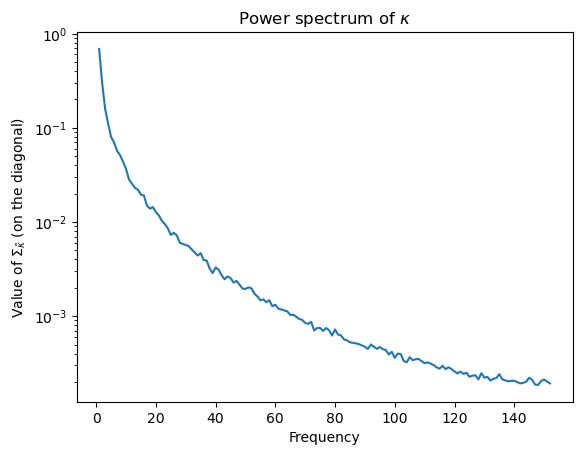

In [37]:
plt.plot(np.arange(1, width//2), powerspectrum_1d[1:])
plt.yscale('log')
plt.xlabel("Frequency")
plt.ylabel(r"Value of $\Sigma_\tilde{\kappa}$ (on the diagonal)")
plt.title(r"Power spectrum of $\kappa$")
plt.show()

Compute iterative Wiener algorithm

In [38]:
kappa_wiener, _ = massmap.prox_wiener_filtering(
    sheardata, powerspectrum_1d, Inpaint=False
)

In [39]:
kappa_wiener_noise, _ = massmap.prox_wiener_filtering(
    sheardata, powerspectrum_1d, Inpaint=False,
    PropagateNoise=True, Nrea=Nrea
)
std_wiener = np.std(kappa_wiener_noise, axis=-3)
res_wiener = np.stack(nimgs * [confidence * std_wiener])
kappa_wiener_lo = kappa_wiener - res_wiener
kappa_wiener_hi = kappa_wiener + res_wiener
%xdel kappa_wiener_noise
%store kappa_wiener res_wiener

Stored 'kappa_wiener' (ndarray)
Stored 'res_wiener' (ndarray)


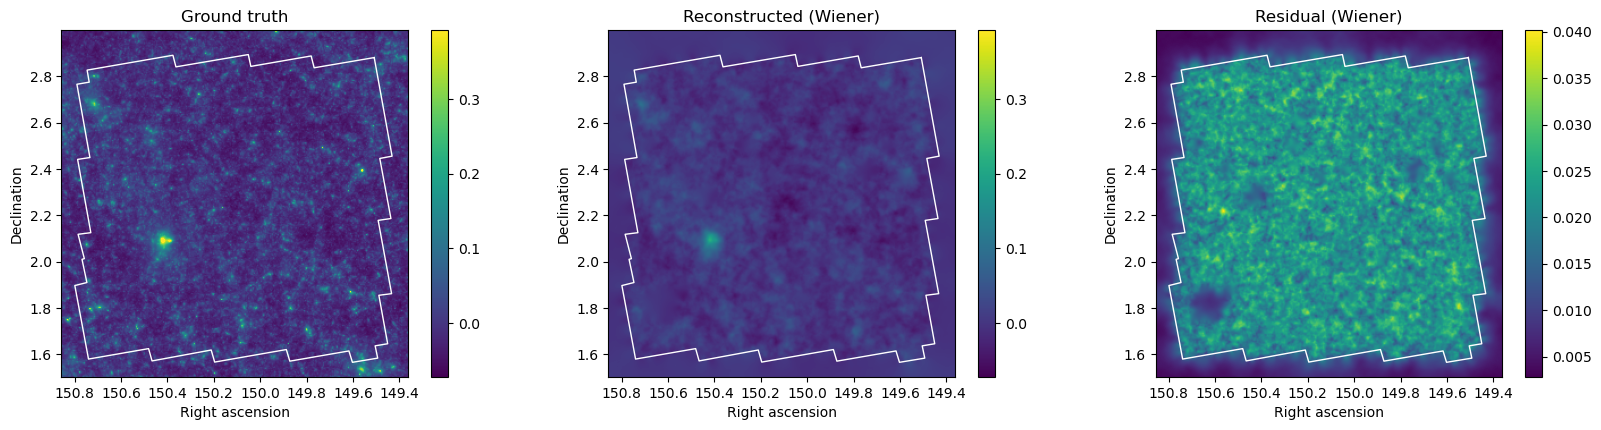

In [40]:
plt.figure(figsize=(20, 4.5))
plt.subplot(131)
wlutils.skyshow(
    kappa[idx], vmin=vmin, vmax=saturation*vmax, extent=extent,
    boundaries=(ra, dec), title="Ground truth"
)
plt.subplot(132)
wlutils.skyshow(
    kappa_wiener[idx], vmin=vmin, vmax=saturation*vmax, extent=extent,
    boundaries=(ra, dec), title="Reconstructed (Wiener)"
)
plt.subplot(133)
wlutils.skyshow(
    res_wiener[idx], extent=extent, boundaries=(ra, dec), title="Residual (Wiener)"
)
plt.show()

#### MCALens estimator

In [41]:
pickle_dir = os.path.expanduser(wl.CONFIG_DATA['pickle_dir'])

fn = os.path.join(pickle_dir, 'mcalens.pred')
with open(fn, 'rb') as f:
    _, kappa_mcalens, _ = pickle.load(f)

fn = os.path.join(pickle_dir, 'mcalens.uq')
with open(fn, 'rb') as f:
    _, std_mcalens, _ = pickle.load(f)
res_mcalens = confidence * std_mcalens
kappa_mcalens_lo = kappa_mcalens - res_mcalens
kappa_mcalens_hi = kappa_mcalens + res_mcalens

%store kappa_mcalens res_mcalens

Stored 'kappa_mcalens' (ndarray)
Stored 'res_mcalens' (ndarray)


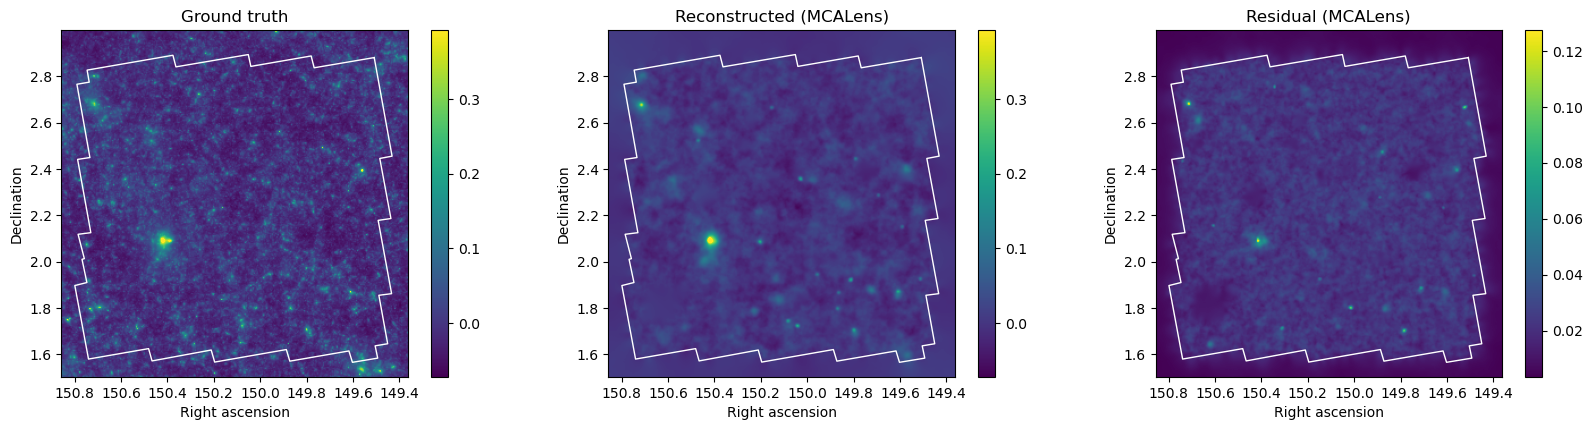

In [42]:
plt.figure(figsize=(20, 4.5))
plt.subplot(131)
wlutils.skyshow(
    kappa[idx], vmin=vmin, vmax=saturation*vmax, extent=extent,
    boundaries=(ra, dec), title="Ground truth"
)
plt.subplot(132)
wlutils.skyshow(
    kappa_mcalens[idx], vmin=vmin, vmax=saturation*vmax, extent=extent,
    boundaries=(ra, dec), title="Reconstructed (MCALens)"
)
plt.subplot(133)
wlutils.skyshow(
    res_mcalens[idx], extent=extent, boundaries=(ra, dec), title="Residual (MCALens)"
)
plt.show()
### Conformal predictions

Split test and calibration sets

In [43]:
[
    kappa_calib,
    kappa_ks_calib, kappa_wiener_calib, kappa_mcalens_calib,
    res_ks_calib, res_wiener_calib, res_mcalens_calib,
    kappa_ks_lo_calib, kappa_wiener_lo_calib, kappa_mcalens_lo_calib,
    kappa_ks_hi_calib, kappa_wiener_hi_calib, kappa_mcalens_hi_calib
], [
    kappa_test,
    kappa_ks_test, kappa_wiener_test, kappa_mcalens_test,
    res_ks_test, res_wiener_test, res_mcalens_test,
    kappa_ks_lo_test, kappa_wiener_lo_test, kappa_mcalens_lo_test,
    kappa_ks_hi_test, kappa_wiener_hi_test, kappa_mcalens_hi_test
] = \
    wlutils.split_test_calib(
        [
            kappa,
            kappa_ks, kappa_wiener, kappa_mcalens,
            res_ks, res_wiener, res_mcalens,
            kappa_ks_lo, kappa_wiener_lo, kappa_mcalens_lo,
            kappa_ks_hi, kappa_wiener_hi, kappa_mcalens_hi
        ], nimgs_calib, calib_first=False
    ) # first the test set; then the calibration set

print(f"Size of the calibration set = {kappa_calib.shape[0]}")
print(f"Size of the test set = {kappa_test.shape[0]}")

Size of the calibration set = 100
Size of the test set = 125


#### Losses before calibration

In [44]:
err_ks_test = wlutils.loss(
    kappa_ks_lo_test, kappa_ks_hi_test, kappa_test, mask=cosmos_mask
)
err_wiener_test = wlutils.loss(
    kappa_wiener_lo_test, kappa_wiener_hi_test, kappa_test, mask=cosmos_mask
)
err_mcalens_test = wlutils.loss(
    kappa_mcalens_lo_test, kappa_mcalens_hi_test, kappa_test, mask=cosmos_mask
)

In [45]:
xticklabels = ["Kaiser-Squires", "Wiener", "MCALens"]

plt.boxplot([err_ks_test, err_wiener_test, err_mcalens_test])
plt.ylim(bottom=0.)
plt.xticks([1, 2, 3], xticklabels)
plt.ylabel("Error rate")
plt.axhline(y=alpha, color='blue', linestyle='--', linewidth=0.8, label='Target')
plt.legend()
plt.title(r"Empirical miscoverage rate")
plt.show()

#### Conformal predictions

Get bounds for the expected error rate

In [46]:
lower_bound_proba, upper_bound_proba = wlutils.get_bounds_proba_cqr(
    alpha, nimgs_calib
)
mid_proba = (upper_bound_proba + lower_bound_proba) / 2

Conformalize and get metrics

In [1]:
calib_func_dict = dict(
    additive=wlutils.conformalize,
    multiplicative=wlutils.conformalize_mult,
    exponential=wlutils.conformalize_exp
)

def conformalize_get_metrics(
        kappa_lo_test, kappa_hi_test, kappa_lo_calib, kappa_hi_calib, kappa_calib,
        alpha, calib_type="additive", **kwargs
):
    # Conformalize
    kappa_lo_cqr_test, kappa_hi_cqr_test, quantile_vals, adjusted_quantile = calib_func_dict[calib_type](
        kappa_lo_test, kappa_hi_test, kappa_lo_calib, kappa_hi_calib,
        kappa_calib, alpha, **kwargs
    )

    # Discard quantile values outside the COSMOS boundaries
    if cosmos_mask is not None:
        quantile_vals = quantile_vals[cosmos_mask]

    # Error rate per image (over pixels)
    err_cqr = wlutils.loss(
        kappa_lo_cqr_test, kappa_hi_cqr_test, kappa_test, mask=cosmos_mask
    )

    # Error rate per pixel (over images)
    err_cqr_perpixel = wlutils.illpredicted_perpixel(kappa_test, kappa_lo_cqr_test, kappa_hi_cqr_test)

    # Mean length of prediction intervals
    mean_predinterv_cqr = wlutils.mean_predinterv(
        kappa_lo_cqr_test, kappa_hi_cqr_test, cosmos_mask=cosmos_mask
    )
    mean_predinterv_cqr_perpixel = wlutils.mean_predinterv_perpixel(
        kappa_lo_cqr_test, kappa_hi_cqr_test
    )

    return quantile_vals, adjusted_quantile, err_cqr, err_cqr_perpixel, \
        mean_predinterv_cqr, mean_predinterv_cqr_perpixel

NameError: name 'wlutils' is not defined

In [48]:
quantile_vals_ks = []
quantile_vals_wiener = []
quantile_vals_mcalens = []

adjusted_quantils_ks = []
adjusted_quantils_wiener = []
adjusted_quantils_mcalens = []

err_cqr_ks = []
err_cqr_wiener = []
err_cqr_mcalens = []

err_cqr_perpixel_ks = []
err_cqr_perpixel_wiener = []
err_cqr_perpixel_mcalens = []

mean_predinterv_cqr_ks = []
mean_predinterv_cqr_wiener = []
mean_predinterv_cqr_mcalens = []

mean_predinterv_perpixel_cqr_ks = []
mean_predinterv_perpixel_cqr_wiener = []
mean_predinterv_perpixel_cqr_mcalens = []

Additive calibration function (original paper)

In [49]:
qv, adjq, err, errperpix, mpredinterv, mpredintervpix = conformalize_get_metrics(
    kappa_ks_lo_test, kappa_ks_hi_test, kappa_ks_lo_calib, kappa_ks_hi_calib, kappa_calib,
    alpha, calib_type="additive"
)
quantile_vals_ks.append(qv)
adjusted_quantils_ks.append(adjq)
err_cqr_ks.append(err)
err_cqr_perpixel_ks.append(errperpix)
mean_predinterv_cqr_ks.append(mpredinterv)
mean_predinterv_perpixel_cqr_ks.append(mpredintervpix)

qv, adjq, err, errperpix, mpredinterv, mpredintervpix = conformalize_get_metrics(
    kappa_wiener_lo_test, kappa_wiener_hi_test, kappa_wiener_lo_calib, kappa_wiener_hi_calib, kappa_calib,
    alpha, calib_type="additive"
)
quantile_vals_wiener.append(qv)
adjusted_quantils_wiener.append(adjq)
err_cqr_wiener.append(err)
err_cqr_perpixel_wiener.append(errperpix)
mean_predinterv_cqr_wiener.append(mpredinterv)
mean_predinterv_perpixel_cqr_wiener.append(mpredintervpix)

qv, adjq, err, errperpix, mpredinterv, mpredintervpix = conformalize_get_metrics(
    kappa_mcalens_lo_test, kappa_mcalens_hi_test, kappa_mcalens_lo_calib, kappa_mcalens_hi_calib, kappa_calib,
    alpha, calib_type="additive"
)
quantile_vals_mcalens.append(qv)
adjusted_quantils_mcalens.append(adjq)
err_cqr_mcalens.append(err)
err_cqr_perpixel_mcalens.append(errperpix)
mean_predinterv_cqr_mcalens.append(mpredinterv)
mean_predinterv_perpixel_cqr_mcalens.append(mpredintervpix)

Multiplicative calibration function (original paper)

In [50]:
qv, adjq, err, errperpix, mpredinterv, mpredintervpix = conformalize_get_metrics(
    kappa_ks_lo_test, kappa_ks_hi_test, kappa_ks_lo_calib, kappa_ks_hi_calib, kappa_calib,
    alpha, calib_type="multiplicative"
)
quantile_vals_ks.append(qv)
adjusted_quantils_ks.append(adjq)
err_cqr_ks.append(err)
err_cqr_perpixel_ks.append(errperpix)
mean_predinterv_cqr_ks.append(mpredinterv)
mean_predinterv_perpixel_cqr_ks.append(mpredintervpix)

qv, adjq, err, errperpix, mpredinterv, mpredintervpix = conformalize_get_metrics(
    kappa_wiener_lo_test, kappa_wiener_hi_test, kappa_wiener_lo_calib, kappa_wiener_hi_calib, kappa_calib,
    alpha, calib_type="multiplicative"
)
quantile_vals_wiener.append(qv)
adjusted_quantils_wiener.append(adjq)
err_cqr_wiener.append(err)
err_cqr_perpixel_wiener.append(errperpix)
mean_predinterv_cqr_wiener.append(mpredinterv)
mean_predinterv_perpixel_cqr_wiener.append(mpredintervpix)

qv, adjq, err, errperpix, mpredinterv, mpredintervpix = conformalize_get_metrics(
    kappa_mcalens_lo_test, kappa_mcalens_hi_test, kappa_mcalens_lo_calib, kappa_mcalens_hi_calib, kappa_calib,
    alpha, calib_type="multiplicative"
)
quantile_vals_mcalens.append(qv)
adjusted_quantils_mcalens.append(adjq)
err_cqr_mcalens.append(err)
err_cqr_perpixel_mcalens.append(errperpix)
mean_predinterv_cqr_mcalens.append(mpredinterv)
mean_predinterv_perpixel_cqr_mcalens.append(mpredintervpix)

Exponential calibration function with
$$\rho(r) = \rho_1(r) := r + \mathrm e^{-r} - 1$$

In [51]:
for scalefact in scalefacts1:

    qv, adjq, err, errperpix, mpredinterv, mpredintervpix = conformalize_get_metrics(
        kappa_ks_lo_test, kappa_ks_hi_test, kappa_ks_lo_calib, kappa_ks_hi_calib, kappa_calib,
        alpha, calib_type="exponential", rho=rho1, scalefact=scalefact, cosmos_mask=cosmos_mask
    )
    quantile_vals_ks.append(qv)
    adjusted_quantils_ks.append(adjq)
    err_cqr_ks.append(err)
    err_cqr_perpixel_ks.append(errperpix)
    mean_predinterv_cqr_ks.append(mpredinterv)
    mean_predinterv_perpixel_cqr_ks.append(mpredintervpix)

    qv, adjq, err, errperpix, mpredinterv, mpredintervpix = conformalize_get_metrics(
        kappa_wiener_lo_test, kappa_wiener_hi_test, kappa_wiener_lo_calib, kappa_wiener_hi_calib, kappa_calib,
        alpha, calib_type="exponential", rho=rho1, scalefact=scalefact, cosmos_mask=cosmos_mask
    )
    quantile_vals_wiener.append(qv)
    adjusted_quantils_wiener.append(adjq)
    err_cqr_wiener.append(err)
    err_cqr_perpixel_wiener.append(errperpix)
    mean_predinterv_cqr_wiener.append(mpredinterv)
    mean_predinterv_perpixel_cqr_wiener.append(mpredintervpix)

    qv, adjq, err, errperpix, mpredinterv, mpredintervpix = conformalize_get_metrics(
        kappa_mcalens_lo_test, kappa_mcalens_hi_test, kappa_mcalens_lo_calib, kappa_mcalens_hi_calib, kappa_calib,
        alpha, calib_type="exponential", rho=rho1, scalefact=scalefact, cosmos_mask=cosmos_mask
    )
    quantile_vals_mcalens.append(qv)
    adjusted_quantils_mcalens.append(adjq)
    err_cqr_mcalens.append(err)
    err_cqr_perpixel_mcalens.append(errperpix)
    mean_predinterv_cqr_mcalens.append(mpredinterv)
    mean_predinterv_perpixel_cqr_mcalens.append(mpredintervpix)

/home/leterme231/OneDrive/Documents/Code/weaklensing/weaklensing/utils.py:442: RuntimeWarning: invalid value encountered in log
  conformity_scores = np.log(
/home/leterme231/miniconda3/envs/wl-pycs/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/leterme231/miniconda3/envs/wl-pycs/lib/python3.11/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


Exponential calibration function with
$$\rho(r) = \rho_2(r) := \beta F_{\chi^2}(r)$$

In [52]:
for scalefact in scalefacts2:

    qv, adjq, err, errperpix, mpredinterv, mpredintervpix = conformalize_get_metrics(
        kappa_ks_lo_test, kappa_ks_hi_test, kappa_ks_lo_calib, kappa_ks_hi_calib, kappa_calib,
        alpha, calib_type="exponential", rho=rho2, scalefact=scalefact, cosmos_mask=cosmos_mask
    )
    quantile_vals_ks.append(qv)
    adjusted_quantils_ks.append(adjq)
    err_cqr_ks.append(err)
    err_cqr_perpixel_ks.append(errperpix)
    mean_predinterv_cqr_ks.append(mpredinterv)
    mean_predinterv_perpixel_cqr_ks.append(mpredintervpix)

    qv, adjq, err, errperpix, mpredinterv, mpredintervpix = conformalize_get_metrics(
        kappa_wiener_lo_test, kappa_wiener_hi_test, kappa_wiener_lo_calib, kappa_wiener_hi_calib, kappa_calib,
        alpha, calib_type="exponential", rho=rho2, scalefact=scalefact, cosmos_mask=cosmos_mask
    )
    quantile_vals_wiener.append(qv)
    adjusted_quantils_wiener.append(adjq)
    err_cqr_wiener.append(err)
    err_cqr_perpixel_wiener.append(errperpix)
    mean_predinterv_cqr_wiener.append(mpredinterv)
    mean_predinterv_perpixel_cqr_wiener.append(mpredintervpix)

    qv, adjq, err, errperpix, mpredinterv, mpredintervpix = conformalize_get_metrics(
        kappa_mcalens_lo_test, kappa_mcalens_hi_test, kappa_mcalens_lo_calib, kappa_mcalens_hi_calib, kappa_calib,
        alpha, calib_type="exponential", rho=rho2, scalefact=scalefact, cosmos_mask=cosmos_mask
    )
    quantile_vals_mcalens.append(qv)
    adjusted_quantils_mcalens.append(adjq)
    err_cqr_mcalens.append(err)
    err_cqr_perpixel_mcalens.append(errperpix)
    mean_predinterv_cqr_mcalens.append(mpredinterv)
    mean_predinterv_perpixel_cqr_mcalens.append(mpredintervpix)

#### Error rates after calibration

In [53]:
xticklabels = ["Uncalibrated", "Additive", "Multiplicative"] + [
    r"$\rho_1$ ($s =$" + f"{(scalefact):.1e})" for scalefact in scalefacts1
] + [
    r"$\rho_2$ ($s =$" + f"{(scalefact):.1e})" for scalefact in scalefacts2
]

def plots_errs(errs, method):
    plt.boxplot(errs)
    plt.ylim(bottom=0.)
    plt.xlabel("Family of calibration functions")
    plt.xticks(np.arange(13) + 1, xticklabels, rotation=90)
    plt.ylabel("Error rate")
    plt.axhline(y=alpha, color='blue', linestyle='--', linewidth=0.8, label='Target')
    plt.legend()
    plt.title(f"Empirical miscoverage rate ({method})")
    plt.show()

def plot_mean_errs(mean_errs, method):
    color_cycle = ['gray'] + plt.rcParams['axes.prop_cycle'].by_key()['color']

    fig, ax = plt.subplots(figsize=(6, 2))
    ax.errorbar(
        mid_proba, 0, xerr=[[mid_proba - lower_bound_proba], [upper_bound_proba - mid_proba]],
        fmt='', color='black', capsize=5, label="Theoretical bounds"
    )
    for i, (err, label) in enumerate(zip(mean_errs, xticklabels)):
        ax.axvline(
            x=mean_errs[i], c=color_cycle[i], linestyle='solid', linewidth=1., label=label
        )
    ax.set_xlim(0., np.ceil(np.max(mean_errs) * 15) / 15)
    ax.set_xlabel('Probability of miscoverage')
    ax.set_yticks([])
    plt.legend(ncol=3, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f"Empirical mean ({method})")
    plt.show()

In [54]:
errs_ks = [err_ks_test] + err_cqr_ks
mean_errs_ks = [np.mean(err) for err in errs_ks]

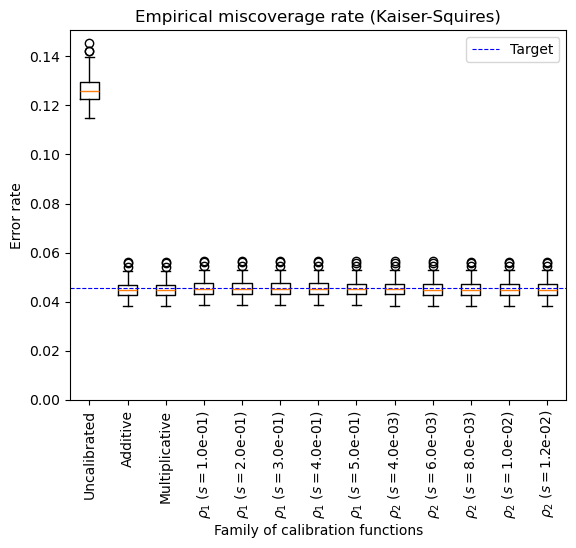

In [55]:
plots_errs(errs_ks, "Kaiser-Squires")

In [56]:
errs_wiener = [err_wiener_test] + err_cqr_wiener
mean_errs_wiener = [np.mean(err) for err in errs_wiener]

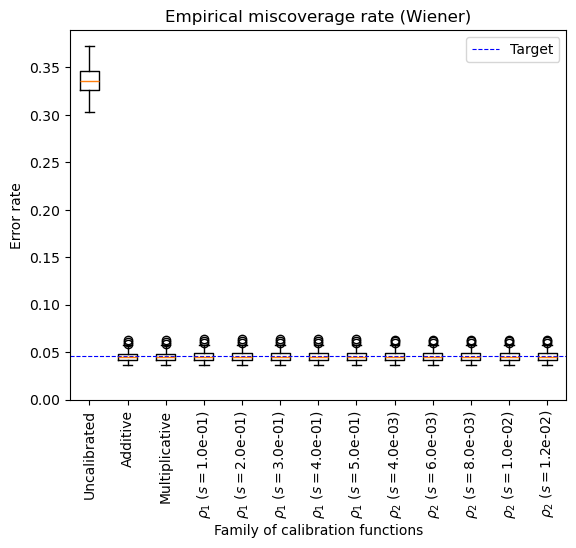

In [57]:
plots_errs(errs_wiener, "Wiener")

In [58]:
errs_mcalens = [err_mcalens_test] + err_cqr_mcalens
mean_errs_mcalens = [np.mean(err) for err in errs_mcalens]

In [59]:
plots_errs(errs_mcalens, "MCALens")

#### Mean length of prediction intervals

In [60]:
mean_predinterv_ks = wlutils.mean_predinterv(
    kappa_ks_lo_test, kappa_ks_hi_test, cosmos_mask=cosmos_mask
)
mean_predinterv_wiener = wlutils.mean_predinterv(
    kappa_wiener_lo_test, kappa_wiener_hi_test, cosmos_mask=cosmos_mask
)
mean_predinterv_mcalens = wlutils.mean_predinterv(
    kappa_mcalens_lo_test, kappa_mcalens_hi_test, cosmos_mask=cosmos_mask
)

mean_predinterv_perpixel_ks = wlutils.mean_predinterv_perpixel(
    kappa_ks_lo_test, kappa_ks_hi_test
)
mean_predinterv_perpixel_wiener = wlutils.mean_predinterv_perpixel(
    kappa_wiener_lo_test, kappa_wiener_hi_test
)
mean_predinterv_perpixel_mcalens = wlutils.mean_predinterv_perpixel(
    kappa_mcalens_lo_test, kappa_mcalens_hi_test
)

In [61]:
def plot_predinterv(mean_predinterv, method, xticklabels=None):
    bar_width = 0.2  # Width of each bar
    xticks = np.arange(len(mean_predinterv))
    if xticklabels is None:
        xticklabels = xticks

    plt.bar(xticks, mean_predinterv, width=bar_width)
    plt.xticks(xticks, xticklabels, rotation=90)
    plt.ylim(top=0.15)
    plt.ylabel(f"Interval length")
    plt.title(f"Mean length of prediction intervals ({method})")
    plt.show()

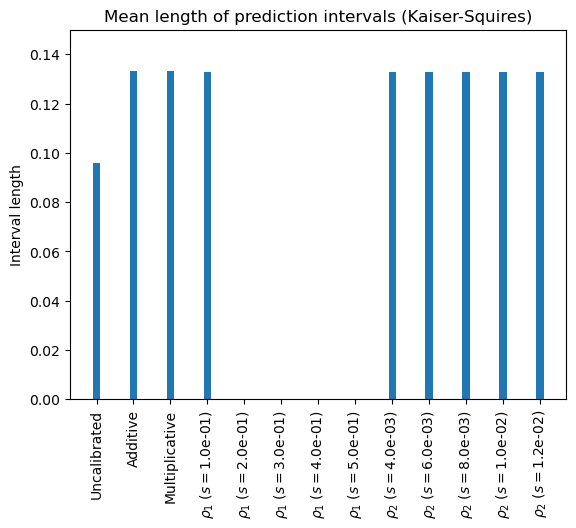

In [62]:
mean_predinterv_ks_0 = [mean_predinterv_ks] + mean_predinterv_cqr_ks
plot_predinterv(mean_predinterv_ks_0, "Kaiser-Squires", xticklabels=xticklabels)

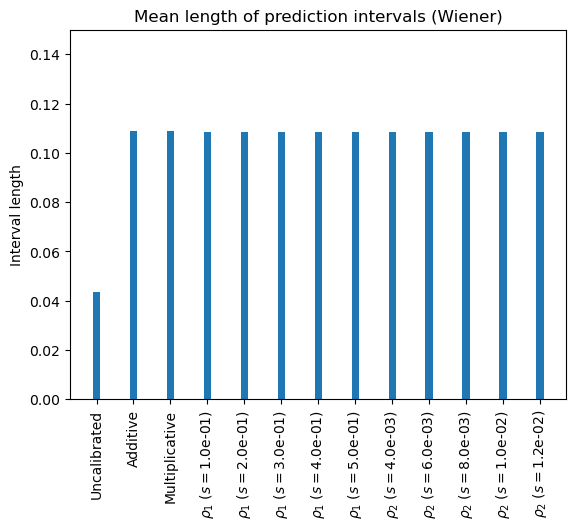

In [63]:
mean_predinterv_wiener_0 = [mean_predinterv_wiener] + mean_predinterv_cqr_wiener
plot_predinterv(mean_predinterv_wiener_0, "Wiener", xticklabels=xticklabels)

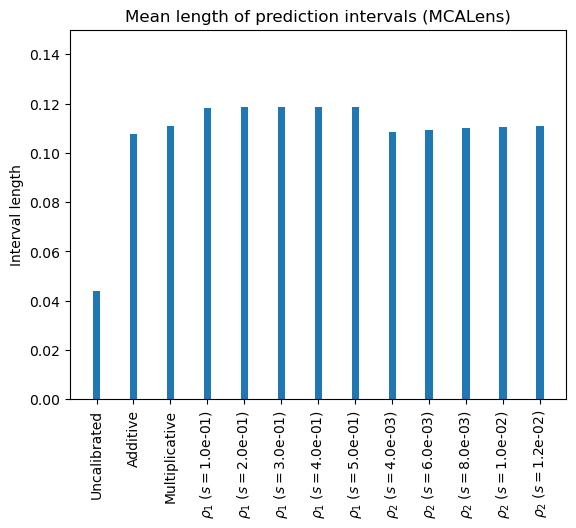

In [64]:
mean_predinterv_mcalens_0 = [mean_predinterv_mcalens] + mean_predinterv_cqr_mcalens
plot_predinterv(mean_predinterv_mcalens_0, "MCALens", xticklabels=xticklabels)

Let's explore more values of `scalefact`.

In [65]:
scalefacts2 = np.logspace(-4, -2, 10)

# Keep additive calibration, for comparison
mean_predinterv_cqr_mcalens = mean_predinterv_cqr_mcalens[:1]

In [66]:
for scalefact in scalefacts2:
    _, _, _, _, mpredinterv, mpredintervpix = conformalize_get_metrics(
        kappa_mcalens_lo_test, kappa_mcalens_hi_test, kappa_mcalens_lo_calib, kappa_mcalens_hi_calib, kappa_calib,
        alpha, calib_type="exponential", rho=rho2, scalefact=scalefact, cosmos_mask=cosmos_mask
    )
    mean_predinterv_cqr_mcalens.append(mpredinterv)

/home/leterme231/OneDrive/Documents/Code/weaklensing/weaklensing/utils.py:442: RuntimeWarning: invalid value encountered in log
  conformity_scores = np.log(


In [67]:
xticklabels = ["Uncalibrated", "Additive"] + [
    r"$\rho_2$ ($s =$" + f"{(scalefact):.1e})" for scalefact in scalefacts2
]

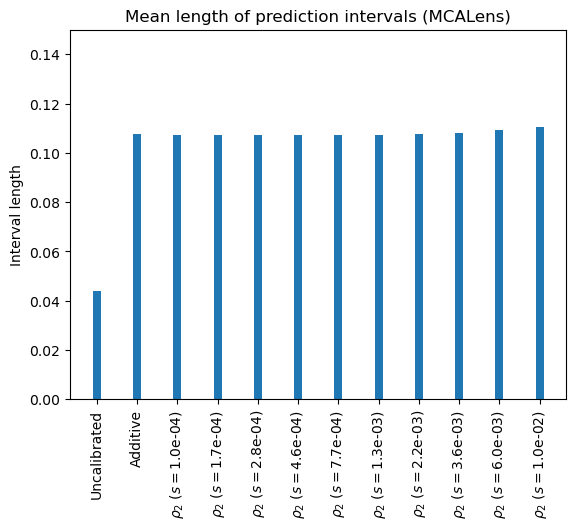

In [68]:
mean_predinterv_mcalens_0 = [mean_predinterv_mcalens] + mean_predinterv_cqr_mcalens
plot_predinterv(mean_predinterv_mcalens_0, "MCALens", xticklabels=xticklabels)

No significant improvement. When $s$ is small, then the calibration function is almost exactly the same as the standard calibration function.